# 12차시: [실습] Open DART API로 기업 공시정보 자동 수집

## 학습 목표
- Open DART API를 활용하여 특정 기업의 사업 보고서, 공시 목록 등 원하는 공시 정보를 파이썬으로 자동 수집
- 여러 기업의 공시 정보를 일괄 수집하는 함수 작성
- 공시 데이터 필터링, 정제, 저장 및 분석

## 학습 내용
1. API 키 설정
2. 여러 기업 공시 목록 수집
3. 공시 정보 필터링 (기간, 유형)
4. 사업보고서 목록 조회
5. 데이터 정제 및 저장 (CSV/Excel)
6. 공시 통계 분석 및 시각화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests
import time

def setup_korean_font_colab(verbose=True):
    """Colab 한글 폰트 설정"""
    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq
        pass
    try:
        fm.fontManager.addfont(font_path)
    except:
        pass
    font_name = fm.FontProperties(fname=font_path).get_name()
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    if verbose:
        print(f"Korean font ready: {font_name}")
    return font_name

setup_korean_font_colab()

Korean font ready: NanumGothic


'NanumGothic'

---
## 1. API 키 설정

11차시와 동일하게 `.env` 파일에서 API 키를 로드합니다.

In [2]:
# API 키 로드 (Colab에서 .env 파일 업로드)
from google.colab import files
import os
from dotenv import load_dotenv

print("[.env 파일 업로드]")
print("=" * 60)
print("로컬에 저장된 .env 파일을 선택해주세요.")
print("(DART_API_KEY가 포함된 파일)")
print()

uploaded = files.upload()

# .env 파일 로드
load_dotenv('.env')

DART_API_KEY = os.getenv('DART_API_KEY')

# API 키 로드 확인
print("\n[API 키 로드 상태]")
print("=" * 60)
if DART_API_KEY:
    print(f"DART API Key: 설정완료 ({DART_API_KEY[:8]}...)")
else:
    print("DART API Key: 미설정")
    print("⚠️ API 키가 없으면 실습을 진행할 수 없습니다.")

[.env 파일 업로드]
로컬에 저장된 .env 파일을 선택해주세요.
(DART_API_KEY가 포함된 파일)



Saving .env to .env (2)

[API 키 로드 상태]
DART API Key: 설정완료 (1493d0f2...)


---
## 2. 여러 기업 공시 목록 수집

여러 기업의 공시 정보를 일괄 수집하는 함수를 작성합니다.

### 주요 기업 고유번호 (corp_code)
| 기업명 | 고유번호 | 종목코드 |
|--------|----------|----------|
| 삼성전자 | 00126380 | 005930 |
| SK하이닉스 | 00164742 | 000660 |
| NAVER | 00140878 | 035420 |
| LG화학 | 00164779 | 051910 |

In [3]:
# import requests
# import zipfile
# import io
# import xml.etree.ElementTree as ET
# import pandas as pd

# def load_corp_codes(api_key: str) -> pd.DataFrame:
#     """
#     DART 전체 기업 고유번호(corp_code) 로드
#     반환: DataFrame [corp_code, corp_name, stock_code]
#     """
#     url = "https://opendart.fss.or.kr/api/corpCode.xml"
#     params = {"crtfc_key": api_key}

#     r = requests.get(url, params=params)
#     z = zipfile.ZipFile(io.BytesIO(r.content))

#     xml_data = z.read('CORPCODE.xml')
#     root = ET.fromstring(xml_data)

#     rows = []
#     for corp in root.findall('list'):
#         rows.append({
#             "corp_code": corp.findtext("corp_code"),
#             "corp_name": corp.findtext("corp_name"),
#             "stock_code": corp.findtext("stock_code")
#         })

#     df = pd.DataFrame(rows)
#     return df

# def find_corp_code(df: pd.DataFrame, corp_name: str):
#     """
#     회사명으로 corp_code 검색
#     (부분 일치 지원)
#     """
#     result = df[df["corp_name"].str.contains(corp_name, na=False)]

#     if result.empty:
#         print("❌ 해당 회사명을 찾을 수 없습니다.")
#         return None

#     return result[["corp_name", "corp_code", "stock_code"]]

# # 1) 전체 기업 목록 로드
# df_corp = load_corp_codes(DART_API_KEY)

# # 2) 회사명으로 검색
# find_corp_code(df_corp, "삼성전자")
# find_corp_code(df_corp, "NAVER")

In [4]:
# 기업 고유번호 사전
corp_codes = {
    "00126380": "삼성전자",
    "00164742": "SK하이닉스",
    "00266961": "NAVER",
    "00164779": "LG화학"
}

print("[분석 대상 기업]")
print("=" * 60)
for code, name in corp_codes.items():
    print(f"  - {name}: {code}")

[분석 대상 기업]
  - 삼성전자: 00126380
  - SK하이닉스: 00164742
  - NAVER: 00266961
  - LG화학: 00164779


In [5]:
# 여러 기업 공시 수집 함수
def collect_disclosures(corp_codes_dict, start_date, end_date, page_count=100):
    """
    여러 기업의 공시 목록을 수집하는 함수

    Parameters:
    -----------
    corp_codes_dict : dict
        {고유번호: 기업명} 형식의 딕셔너리
    start_date : str
        시작일 (YYYYMMDD)
    end_date : str
        종료일 (YYYYMMDD)
    page_count : int
        페이지당 조회 건수 (기본값: 100)

    Returns:
    --------
    DataFrame : 모든 기업의 공시 정보를 합친 DataFrame
    """
    all_disclosures = []

    print(f"[공시 수집 기간: {start_date} ~ {end_date}]")
    print("=" * 60)

    url = "https://opendart.fss.or.kr/api/list.json"

    for corp_code, corp_name in corp_codes_dict.items():
        params = {
            "crtfc_key": DART_API_KEY,
            "corp_code": corp_code,
            "bgn_de": start_date,
            "end_de": end_date,
            "page_count": str(page_count)
        }

        try:
            response = requests.get(url, params=params)

            if response.status_code == 200:
                data = response.json()

                if data['status'] == '000':
                    disclosures = data['list']
                    print(f"  ✓ {corp_name}: {len(disclosures)}건 수집")

                    # 기업명 추가
                    for item in disclosures:
                        item['corp_name'] = corp_name

                    all_disclosures.extend(disclosures)
                else:
                    print(f"  ✗ {corp_name}: 오류 - {data.get('message', '')}")
            else:
                print(f"  ✗ {corp_name}: HTTP 오류 - {response.status_code}")

            # API 호출 제한 고려 (0.1초 대기)
            time.sleep(0.1)

        except Exception as e:
            print(f"  ✗ {corp_name}: 예외 발생 - {e}")

    # DataFrame으로 변환
    if all_disclosures:
        df = pd.DataFrame(all_disclosures)
        print(f"\n총 {len(df)}건의 공시 정보 수집 완료")
        return df
    else:
        print("\n수집된 공시 정보가 없습니다.")
        return pd.DataFrame()

In [ ]:
# 최근 3개월 공시 정보 수집
end_date = datetime.now()
start_date = end_date - timedelta(days=90)

start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

print(f"[최근 3개월 공시 정보 수집]")
print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
print()

df_disclosures = collect_disclosures(corp_codes, start_str, end_str, page_count=100)

In [6]:
df_disclosures.head()

[최근 3개월 공시 정보 수집]
기간: 2025-10-03 ~ 2026-01-01

[공시 수집 기간: 20251003 ~ 20260101]
  ✓ 삼성전자: 100건 수집
  ✓ SK하이닉스: 25건 수집
  ✓ NAVER: 38건 수집
  ✓ LG화학: 71건 수집

총 234건의 공시 정보 수집 완료


,corp_code,corp_name,stock_code,corp_cls,report_nm,rcept_no,flr_nm,rcept_dt,rm
0,00126380,삼성전자,005930,Y,임원ㆍ주요주주특정증권등소유상황보고서,20251231000603,홍창표,20251231,
1,00126380,삼성전자,005930,Y,임원ㆍ주요주주특정증권등소유상황보고서,20251230000010,이병철,20251230,
2,00126380,삼성전자,005930,Y,중대재해발생(종속회사의주요경영사항),20251224800811,삼성전자,20251224,유
3,00126380,삼성전자,005930,Y,임원ㆍ주요주주특정증권등소유상황보고서,20251218000407,이승구,20251218,
4,00126380,삼성전자,005930,Y,임원ㆍ주요주주특정증권등소유상황보고서,20251217000017,박준성,20251217,


In [7]:
# 수집된 공시 정보 확인
from IPython.display import HTML

print("\n[수집된 공시 정보 샘플]")
print("=" * 60)

# 주요 컬럼만 선택
display_cols = ['rcept_dt', 'corp_name', 'report_nm', 'flr_nm']
if 'rcept_no' in df_disclosures.columns:
    display_cols.append('rcept_no')

df_display = df_disclosures[display_cols].copy()
df_display.columns = ['접수일자', '기업명', '보고서명', '제출인', '접수번호']

# 링크 추가 및 보고서명을 클릭 가능하게
if '접수번호' in df_display.columns:
    df_display['공시링크'] = df_display['접수번호'].apply(
        lambda x: f"https://dart.fss.or.kr/dsaf001/main.do?rcpNo={x}" if pd.notna(x) else ""
    )
    
    def make_report_link(row):
        report_name = row['보고서명']
        link = row['공시링크']
        if link != "":
            return f'<a href="{link}" target="_blank">{report_name}</a>'
        return report_name
    
    df_display['보고서명'] = df_display.apply(make_report_link, axis=1)
    df_display = df_display.drop(['접수번호', '공시링크'], axis=1)

print(f"총 {len(df_display)}건")
print("\n처음 10건 (보고서명 클릭 시 DART 공시 페이지로 이동):")
HTML(df_display.head(10).to_html(escape=False))


[수집된 공시 정보 샘플]
총 234건

처음 10건 (보고서명 클릭 시 DART 공시 페이지로 이동):


,접수일자,기업명,보고서명,제출인
0,20251231,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,홍창표
1,20251230,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,이병철
2,20251224,삼성전자,중대재해발생(종속회사의주요경영사항),삼성전자
3,20251218,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,이승구
4,20251217,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,박준성
5,20251216,삼성전자,[기재정정]임원ㆍ주요주주특정증권등소유상황보고서,문원민
6,20251215,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,김재훈
7,20251212,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,김유석
8,20251211,삼성전자,임원ㆍ주요주주특정증권등소유상황보고서,김유석
9,20251210,삼성전자,[기재정정]임원ㆍ주요주주특정증권등소유상황보고서,김유석


---
## 3. 공시 정보 필터링 (기간, 유형)

수집한 공시 정보를 기간, 유형 등으로 필터링합니다.

In [8]:
# 정기보고서만 필터링 (보고서명 기반)
from IPython.display import HTML

print("\n[정기보고서만 필터링]")
print("=" * 60)

# 사업보고서, 반기보고서, 분기보고서 포함
df_annual = df_disclosures[
    df_disclosures['report_nm'].str.contains('사업보고서|반기보고서|분기보고서', na=False, regex=True)
].copy()

print(f"정기보고서: {len(df_annual)}건")

print("\n정기보고서 목록 (보고서명 클릭 시 DART 공시 페이지로 이동):")
df_annual_display = df_annual[['rcept_dt', 'corp_name', 'report_nm', 'rcept_no']].copy()
df_annual_display.columns = ['접수일자', '기업명', '보고서명', '접수번호']

# 보고서명을 클릭 가능한 링크로 변환
if '접수번호' in df_annual_display.columns:
    df_annual_display['공시링크'] = df_annual_display['접수번호'].apply(
        lambda x: f"https://dart.fss.or.kr/dsaf001/main.do?rcpNo={x}" if pd.notna(x) else ""
    )
    
    def make_report_link(row):
        report_name = row['보고서명']
        link = row['공시링크']
        if link != "":
            return f'<a href="{link}" target="_blank">{report_name}</a>'
        return report_name
    
    df_annual_display['보고서명'] = df_annual_display.apply(make_report_link, axis=1)
    df_annual_display = df_annual_display.drop(['접수번호', '공시링크'], axis=1)

HTML(df_annual_display.head(20).to_html(escape=False))


[정기보고서만 필터링]
정기보고서: 4건

정기보고서 목록 (보고서명 클릭 시 DART 공시 페이지로 이동):


,접수일자,기업명,보고서명
94,20251114,삼성전자,분기보고서 (2025.09)
109,20251114,SK하이닉스,분기보고서 (2025.09)
150,20251114,NAVER,분기보고서 (2025.09)
183,20251114,LG화학,분기보고서 (2025.09)


In [ ]:
# 기업별 공시 건수 분석
if len(df_disclosures) > 0:
    print("\n[기업별 공시 건수]")
    print("=" * 60)

    corp_counts = df_disclosures['corp_name'].value_counts()

    for corp_name, count in corp_counts.items():
        print(f"  {corp_name}: {count}건")

    # 시각화
    plt.figure(figsize=(10, 5))
    corp_counts.plot(kind='barh', color='navy', edgecolor='black')
    plt.title('기업별 공시 건수', fontsize=14, fontweight='bold')
    plt.xlabel('건수', fontsize=12)
    plt.ylabel('기업명', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## 4. 데이터 정제 및 저장 (CSV/Excel)

수집한 공시 정보를 정제하고 CSV/Excel 파일로 저장합니다.

In [9]:
# 데이터 정제
print("[데이터 정제]")
print("=" * 60)

# 필요한 컬럼만 선택 (pblntf_ty 제외)
available_cols = df_disclosures.columns.tolist()
cols_to_select = ['rcept_dt', 'corp_name', 'stock_code', 'corp_code', 'report_nm', 'flr_nm', 'rm', 'rcept_no']
cols_to_select = [col for col in cols_to_select if col in available_cols]

df_clean = df_disclosures[cols_to_select].copy()

# 컬럼명 한글화
col_mapping = {
    'rcept_dt': '접수일자',
    'corp_name': '기업명',
    'stock_code': '종목코드',
    'corp_code': '고유번호',
    'report_nm': '보고서명',
    'flr_nm': '제출인',
    'rm': '비고',
    'rcept_no': '접수번호'
}
df_clean.columns = [col_mapping.get(col, col) for col in df_clean.columns]

# DART 공시 링크 추가
if '접수번호' in df_clean.columns:
    df_clean['공시링크'] = df_clean['접수번호'].apply(
        lambda x: f"https://dart.fss.or.kr/dsaf001/main.do?rcpNo={x}" if pd.notna(x) else ""
    )
else:
    print("⚠️ 접수번호(rcept_no) 컬럼이 없어 링크를 생성할 수 없습니다.")

# 보고서 유형 추가 (보고서명 기반)
def get_report_type(report_nm):
    if pd.isna(report_nm):
        return "기타"
    report_nm = str(report_nm)
    if "사업보고서" in report_nm:
        return "사업보고서"
    elif "반기보고서" in report_nm:
        return "반기보고서"
    elif "분기보고서" in report_nm or "1분기" in report_nm or "3분기" in report_nm:
        return "분기보고서"
    elif "주요사항" in report_nm:
        return "주요사항"
    elif "발행공시" in report_nm:
        return "발행공시"
    else:
        return "기타"

df_clean['보고서유형'] = df_clean['보고서명'].apply(get_report_type)

# 접수일자를 날짜 형식으로 변환
df_clean['접수일자'] = pd.to_datetime(df_clean['접수일자'])

# 정렬 (최신순)
df_clean = df_clean.sort_values('접수일자', ascending=False).reset_index(drop=True)

print(f"정제 완료: {len(df_clean)}건")
print(f"\n컬럼: {df_clean.columns.tolist()}")

# HTML로 표시 (보고서명을 클릭 가능한 링크로)
from IPython.display import HTML

def make_report_link(row):
    """보고서명을 클릭 가능한 HTML 링크로 변환"""
    report_name = row['보고서명']
    link = row['공시링크']
    if pd.notna(link) and link != "":
        return f'<a href="{link}" target="_blank">{report_name}</a>'
    return report_name

df_display_html = df_clean.head(10).copy()
if '공시링크' in df_display_html.columns:
    df_display_html['보고서명'] = df_display_html.apply(make_report_link, axis=1)
    
    # 공시링크 컬럼은 제외하고 표시
    display_cols = ['접수일자', '기업명', '보고서명', '보고서유형']
    print("\n샘플 데이터 (보고서명 클릭 시 DART 공시 페이지로 이동):")
    HTML(df_display_html[display_cols].to_html(escape=False))
else:
    print("\n샘플 데이터:")
    df_clean.head()

[데이터 정제 + CSV 저장]
      접수일자    기업명                               보고서명           접수번호    제출인 비고                                                        공시링크 보고서유형
2025-12-31   삼성전자                임원ㆍ주요주주특정증권등소유상황보고서 20251231000603    홍창표    https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20251231000603    기타
2025-12-31  NAVER                임원ㆍ주요주주특정증권등소유상황보고서 20251231000459    박우성    https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20251231000459    기타
2025-12-31 SK하이닉스 대표이사(대표집행임원)변경(안내공시)               20251231800663  현대자동차  유 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20251231800663    기타
2025-12-30   삼성전자                임원ㆍ주요주주특정증권등소유상황보고서 20251230000010    이병철    https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20251230000010    기타
2025-12-29  NAVER                임원ㆍ주요주주특정증권등소유상황보고서 20251229000488    정경화    https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20251229000488    기타
2025-12-29  NAVER                임원ㆍ주요주주특정증권등소유상황보고서 20251229000455    오현진    https://dart.fss.or.kr/dsaf001/main.do?r

In [ ]:
print("\n[CSV 파일 저장]")
print("=" * 60)

csv_filename = f"공시정보_{start_str}_{end_str}.csv"
df_clean.to_csv(csv_filename, index=False, encoding='utf-8-sig')

print(f"저장 완료: {csv_filename}")
print(f"파일 크기: {os.path.getsize(csv_filename) / 1024:.2f} KB")
if '공시링크' in df_clean.columns:
    print("✓ CSV 파일에 공시링크가 포함되어 있습니다.")

---
## 5. 공시 통계 분석 및 시각화

수집한 공시 정보를 분석하고 시각화합니다.

[월별 공시 건수 분석]

월별 공시 건수:
  2025-10: 70건
  2025-11: 75건
  2025-12: 89건


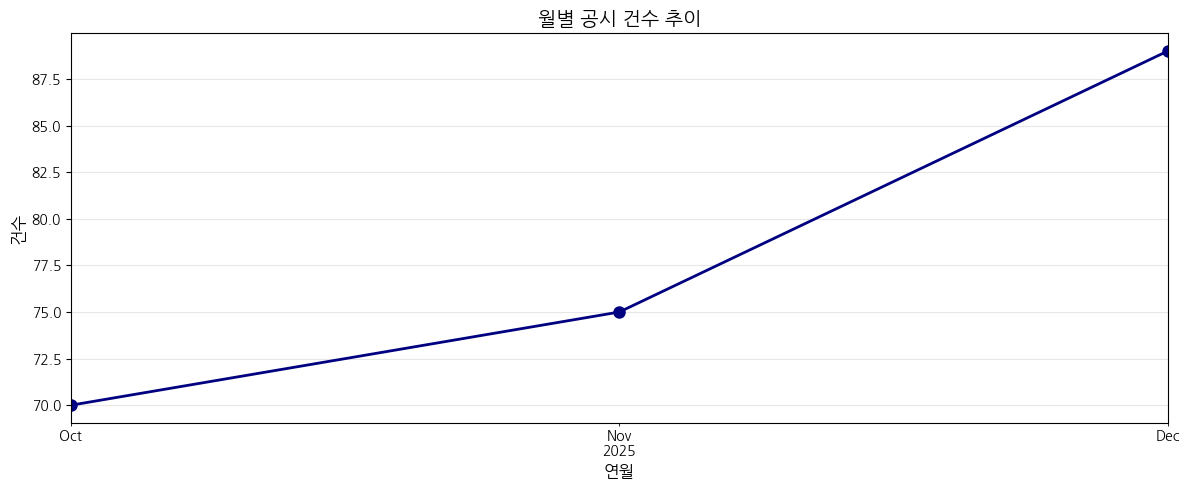

In [10]:
print("[월별 공시 건수 분석]")
print("=" * 60)

# 접수일자에서 연월 추출
df_clean['연월'] = df_clean['접수일자'].dt.to_period('M')

monthly_counts = df_clean.groupby('연월').size()

print("\n월별 공시 건수:")
for period, count in monthly_counts.items():
    print(f"  {period}: {count}건")

# 시각화
plt.figure(figsize=(12, 5))
monthly_counts.plot(kind='line', marker='o', linewidth=2, markersize=8, color='navy')
plt.title('월별 공시 건수 추이', fontsize=14, fontweight='bold')
plt.xlabel('연월', fontsize=12)
plt.ylabel('건수', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[기업별 공시 건수]
  삼성전자: 100건
  LG화학: 71건
  NAVER: 38건
  SK하이닉스: 25건


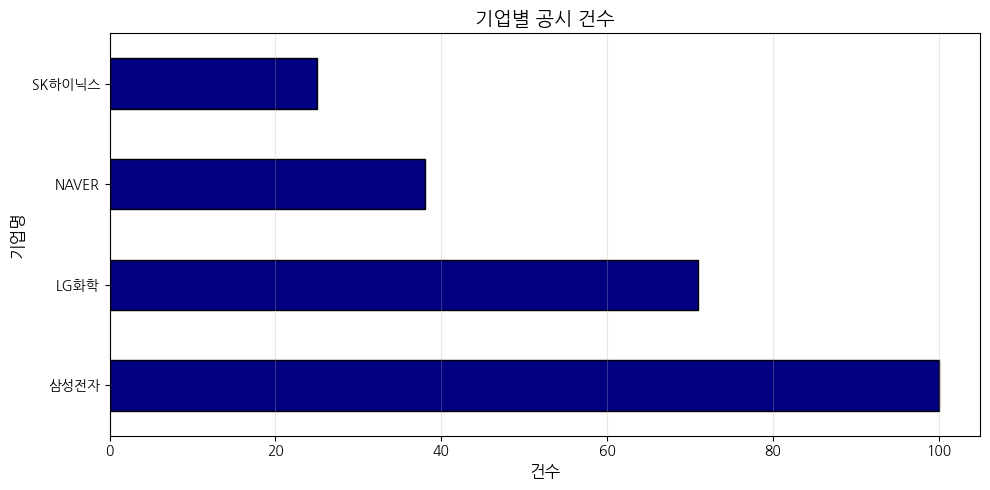

In [11]:
# 최근 공시 Top 10 (클릭 가능한 링크 포함)
from IPython.display import HTML

if len(df_disclosures) > 0 and '보고서유형' in df_clean.columns:
    print("\n[최근 공시 Top 10]")
    print("=" * 60)
    
    top10 = df_clean.head(10).copy()
    
    # 공시링크가 있으면 보고서명을 링크로 변환
    if '공시링크' in top10.columns:
        def make_report_link(row):
            report_name = row['보고서명']
            link = row['공시링크']
            if pd.notna(link) and link != "":
                return f'<a href="{link}" target="_blank">{report_name}</a>'
            return report_name
        
        top10['보고서명'] = top10.apply(make_report_link, axis=1)
        
        # 공시링크 컬럼은 제외하고 표시
        display_cols = ['접수일자', '기업명', '보고서명', '보고서유형']
        print("(보고서명 클릭 시 DART 공시 페이지로 이동)")
        HTML(top10[display_cols].to_html(escape=False))
    else:
        display_cols = ['접수일자', '기업명', '보고서명', '보고서유형']
        HTML(top10[display_cols].to_html(escape=False))

---
## 학습 정리

### 1. 여러 기업 공시 수집
- `collect_disclosures()` 함수로 여러 기업의 공시 정보를 일괄 수집
- API 호출 제한을 고려한 대기 시간 설정 (`time.sleep()`)

### 2. 공시 정보 필터링
- 보고서명 기반 유형 추출 및 필터링
- 기간별 필터링
- 보고서명으로 필터링 (사업보고서, 반기보고서 등)

### 3. 데이터 정제
- 필요한 컬럼만 선택
- 컬럼명 한글화
- DART 공시 링크 생성 (`공시링크` 컬럼)
- 날짜 형식 변환
- 정렬 및 인덱스 리셋

### 4. 데이터 저장
- CSV 파일 저장 (`to_csv()`) - 공시링크 포함
- Excel 파일 저장 (`to_excel()`, 여러 시트)

### 5. HTML 링크 표시
- `IPython.display.HTML` 사용
- 보고서명을 클릭 가능한 하이퍼링크로 변환
- Jupyter/Colab에서 직접 DART 공시 페이지로 이동 가능

### 6. 통계 분석 및 시각화
- 월별 공시 건수 추이
- 최근 공시 Top 10 (HTML 링크 포함)
- Matplotlib으로 시각화

### 핵심 함수
```python
collect_disclosures(corp_codes_dict, start_date, end_date, page_count)
```

---

### 다음 차시 예고
- 13차시: [실습] FRED API로 경제지표 수집
  - 미국 경제지표 자동 수집
  - 여러 지표 비교 분석